In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import logging
from time import sleep
import os
from dotenv import load_dotenv
import psycopg2

In [374]:
pd.set_option('display.max_columns', None)

In [375]:
load_dotenv()
logger = logging.getLogger('pro_data_extraction')

import warnings
warnings.filterwarnings('ignore')

db_name = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')
password = os.getenv('POSTGRES_PASSWORD')
host = 'localhost'
port = '5432'

conn = psycopg2.connect(dbname=db_name, user=user, password=password, host=host, port=port)

In [376]:
cur = conn.cursor()

query = """
    SELECT 
        *
    FROM dota_dds.pro_matches pm 
    LEFT JOIN dota_dds.leagues l 
        ON (pm.match_data ->> 'leagueid')::integer = l.league_id
    WHERE l.allowed = True
"""

cur.execute(query)

rows = cur.fetchall()
df_pro = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])

query = """
    SELECT *

    FROM dota_dds.public_matches
"""

cur.execute(query)

rows = cur.fetchall()
df_public = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])

cur.close()
conn.close()

In [377]:
df_pro.head(10)

,match_id,series_id,match_data,is_live,raw_dt,league_id,league_name,tier,allowed
0,7230110109,None,"{'players': [{'account_id': 86745912, 'player_...",False,2023-07-10,15438,The Bali Major,premium,True
1,7230050142,None,"{'players': [{'account_id': 86745912, 'player_...",False,2023-07-10,15438,The Bali Major,premium,True
2,7230010951,None,"{'players': [{'account_id': 1171243748, 'playe...",False,2023-07-10,15438,The Bali Major,premium,True
3,7229957170,None,"{'players': [{'account_id': 321580662, 'player...",False,2023-07-10,15438,The Bali Major,premium,True
4,7229895052,None,"{'players': [{'account_id': 321580662, 'player...",False,2023-07-10,15438,The Bali Major,premium,True
5,7229857152,None,"{'players': [{'account_id': 320252024, 'player...",False,2023-07-10,15438,The Bali Major,premium,True
6,7229648205,None,"{'players': [{'account_id': 140251702, 'player...",False,2023-07-10,14691,European Pro League 2022-2023 Season,professional,True
7,6652699293,None,"{'players': [{'account_id': 294135421, 'player...",False,2023-07-15,13379,Dota 2 Champions League 2021-2022 Season,professional,True
8,7229580551,None,"{'players': [{'account_id': 115464954, 'player...",False,2023-07-10,14691,European Pro League 2022-2023 Season,professional,True
9,7229452975,None,"{'players': [{'account_id': 140251702, 'player...",False,2023-07-10,14691,European Pro League 2022-2023 Season,professional,True


In [378]:
df_public.head(10)

,match_id,start_time,duration,game_mode,avg_rank_tier,radiant_team,dire_team,radiant_win,raw_dt
0,7219927210,1687975187,3708,22,81,"[128, 2, 9, 114, 121]","[100, 105, 10, 120, 61]",True,2023-07-03
1,7219928100,1687975232,1519,22,81,"[128, 71, 22, 120, 63]","[40, 106, 44, 56, 58]",True,2023-07-03
2,7219928202,1687975232,1315,22,81,"[40, 11, 78, 23, 31]","[1, 103, 9, 20, 25]",True,2023-07-03
3,7219928405,1687975228,1781,22,81,"[64, 2, 8, 82, 90]","[71, 104, 40, 76, 89]",True,2023-07-03
4,7219932418,1687975442,2059,22,81,"[129, 35, 18, 62, 31]","[11, 17, 86, 120, 61]",True,2023-07-03
5,7219932805,1687975458,1989,22,81,"[64, 4, 104, 106, 14]","[98, 37, 119, 89, 59]",True,2023-07-03
6,7219933015,1687975467,1042,22,81,"[4, 10, 14, 56, 120]","[41, 45, 52, 87, 55]",True,2023-07-03
7,7219934518,1687975548,2028,22,81,"[36, 104, 111, 86, 95]","[1, 40, 80, 17, 26]",True,2023-07-03
8,7219935800,1687975609,2732,22,81,"[128, 34, 88, 29, 94]","[1, 101, 104, 9, 58]",False,2023-07-03
9,7219936704,1687975648,1949,22,81,"[128, 40, 44, 49, 20]","[98, 5, 6, 71, 14]",True,2023-07-03


In [379]:
df_pro['start_time'] = df_pro['match_data'].apply(lambda x: x.get('start_time'))

In [380]:
def unix_to_columns(df):
    df['start_time'] = pd.to_datetime(df['start_time'], unit = 's')
    df['year'] = df['start_time'].dt.year
    df['month'] = df['start_time'].dt.month
    df['day'] = df['start_time'].dt.day


In [381]:
unix_to_columns(df_pro)

In [382]:
all_hero_ids = set(range(1, 141))
for team_number in range(2):
    for hero_id in all_hero_ids:
            column_name = f'hero_{hero_id}_team_{team_number}'
            df_pro[column_name] = df_pro['match_data'].apply(lambda x: 1 if any(player.get('hero_id') == hero_id \
                                    and player.get('team_number') == team_number for player in x.get('players', {})) else 0)

In [383]:
df_pro['result'] = df_pro['match_data'].apply(lambda x: 1 if x.get('radiant_win') else 0)

In [384]:
df_pro_train = df_pro.loc[df_pro['league_id'] != 15438].drop(columns = ['match_id', 'series_id', 'is_live', 
                                   'raw_dt', 'league_name', 'tier',  
                                   'allowed', 'match_data', 'league_id', 'start_time'])

df_pro_test = df_pro.loc[(df_pro['league_id'].isin([15475, 15438])) & (df_pro['match_id'] > 7213882342)].drop(columns = ['match_id', 'series_id', 'is_live', 
                                   'raw_dt', 'league_name', 'tier', 
                                   'allowed', 'match_data', 'league_id', 'start_time'])

In [385]:
df_pro_train.head(3)

,year,month,day,hero_1_team_0,hero_2_team_0,hero_3_team_0,hero_4_team_0,hero_5_team_0,hero_6_team_0,hero_7_team_0,hero_8_team_0,hero_9_team_0,hero_10_team_0,hero_11_team_0,hero_12_team_0,hero_13_team_0,hero_14_team_0,hero_15_team_0,hero_16_team_0,hero_17_team_0,hero_18_team_0,hero_19_team_0,hero_20_team_0,hero_21_team_0,hero_22_team_0,hero_23_team_0,hero_24_team_0,hero_25_team_0,hero_26_team_0,hero_27_team_0,hero_28_team_0,hero_29_team_0,hero_30_team_0,hero_31_team_0,hero_32_team_0,hero_33_team_0,hero_34_team_0,hero_35_team_0,hero_36_team_0,hero_37_team_0,hero_38_team_0,hero_39_team_0,hero_40_team_0,hero_41_team_0,hero_42_team_0,hero_43_team_0,hero_44_team_0,hero_45_team_0,hero_46_team_0,hero_47_team_0,hero_48_team_0,hero_49_team_0,hero_50_team_0,hero_51_team_0,hero_52_team_0,hero_53_team_0,hero_54_team_0,hero_55_team_0,hero_56_team_0,hero_57_team_0,hero_58_team_0,hero_59_team_0,hero_60_team_0,hero_61_team_0,hero_62_team_0,hero_63_team_0,hero_64_team_0,hero_65_team_0,hero_66_team_0,hero_67_team_0,hero_68_team_0,hero_69_team_0,hero_70_team_0,hero_71_team_0,hero_72_team_0,hero_73_team_0,hero_74_team_0,hero_75_team_0,hero_76_team_0,hero_77_team_0,hero_78_team_0,hero_79_team_0,hero_80_team_0,hero_81_team_0,hero_82_team_0,hero_83_team_0,hero_84_team_0,hero_85_team_0,hero_86_team_0,hero_87_team_0,hero_88_team_0,hero_89_team_0,hero_90_team_0,hero_91_team_0,hero_92_team_0,hero_93_team_0,hero_94_team_0,hero_95_team_0,hero_96_team_0,hero_97_team_0,hero_98_team_0,hero_99_team_0,hero_100_team_0,hero_101_team_0,hero_102_team_0,hero_103_team_0,hero_104_team_0,hero_105_team_0,hero_106_team_0,hero_107_team_0,hero_108_team_0,hero_109_team_0,hero_110_team_0,hero_111_team_0,hero_112_team_0,hero_113_team_0,hero_114_team_0,hero_115_team_0,hero_116_team_0,hero_117_team_0,hero_118_team_0,hero_119_team_0,hero_120_team_0,hero_121_team_0,hero_122_team_0,hero_123_team_0,hero_124_team_0,hero_125_team_0,hero_126_team_0,hero_127_team_0,hero_128_team_0,hero_129_team_0,hero_130_team_0,hero_131_team_0,hero_132_team_0,hero_133_team_0,hero_134_team_0,hero_135_team_0,hero_136_team_0,hero_137_team_0,hero_138_team_0,hero_139_team_0,hero_140_team_0,hero_1_team_1,hero_2_team_1,hero_3_team_1,hero_4_team_1,hero_5_team_1,hero_6_team_1,hero_7_team_1,hero_8_team_1,hero_9_team_1,hero_10_team_1,hero_11_team_1,hero_12_team_1,hero_13_team_1,hero_14_team_1,hero_15_team_1,hero_16_team_1,hero_17_team_1,hero_18_team_1,hero_19_team_1,hero_20_team_1,hero_21_team_1,hero_22_team_1,hero_23_team_1,hero_24_team_1,hero_25_team_1,hero_26_team_1,hero_27_team_1,hero_28_team_1,hero_29_team_1,hero_30_team_1,hero_31_team_1,hero_32_team_1,hero_33_team_1,hero_34_team_1,hero_35_team_1,hero_36_team_1,hero_37_team_1,hero_38_team_1,hero_39_team_1,hero_40_team_1,hero_41_team_1,hero_42_team_1,hero_43_team_1,hero_44_team_1,hero_45_team_1,hero_46_team_1,hero_47_team_1,hero_48_team_1,hero_49_team_1,hero_50_team_1,hero_51_team_1,hero_52_team_1,hero_53_team_1,hero_54_team_1,hero_55_team_1,hero_56_team_1,hero_57_team_1,hero_58_team_1,hero_59_team_1,hero_60_team_1,hero_61_team_1,hero_62_team_1,hero_63_team_1,hero_64_team_1,hero_65_team_1,hero_66_team_1,hero_67_team_1,hero_68_team_1,hero_69_team_1,hero_70_team_1,hero_71_team_1,hero_72_team_1,hero_73_team_1,hero_74_team_1,hero_75_team_1,hero_76_team_1,hero_77_team_1,hero_78_team_1,hero_79_team_1,hero_80_team_1,hero_81_team_1,hero_82_team_1,hero_83_team_1,hero_84_team_1,hero_85_team_1,hero_86_team_1,hero_87_team_1,hero_88_team_1,hero_89_team_1,hero_90_team_1,hero_91_team_1,hero_92_team_1,hero_93_team_1,hero_94_team_1,hero_95_team_1,hero_96_team_1,hero_97_team_1,hero_98_team_1,hero_99_team_1,hero_100_team_1,hero_101_team_1,hero_102_team_1,hero_103_team_1,hero_104_team_1,hero_105_team_1,hero_106_team_1,hero_107_team_1,hero_108_team_1,hero_109_team_1,hero_110_team_1,hero_111_team_1,hero_112_team_1,hero_113_team_1,hero_114_team_1,hero_115_team_1,hero_116_team_1,hero_117_team_1,hero_118_team_1,hero_119_team_1,hero_120_team_1,hero_121_team_1,hero_122_team_1,hero_123

In [386]:
unix_to_columns(df_public)

In [387]:
df_public.head(3)

,match_id,start_time,duration,game_mode,avg_rank_tier,radiant_team,dire_team,radiant_win,raw_dt,year,month,day
0,7219927210,2023-06-28 17:59:47,3708,22,81,"[128, 2, 9, 114, 121]","[100, 105, 10, 120, 61]",True,2023-07-03,2023,6,28
1,7219928100,2023-06-28 18:00:32,1519,22,81,"[128, 71, 22, 120, 63]","[40, 106, 44, 56, 58]",True,2023-07-03,2023,6,28
2,7219928202,2023-06-28 18:00:32,1315,22,81,"[40, 11, 78, 23, 31]","[1, 103, 9, 20, 25]",True,2023-07-03,2023,6,28


In [388]:
df_public.shape

(41376, 12)

In [389]:
all_hero_ids = set(range(1, 141))
for team_number in ['radiant', 'dire']:
    for hero_id in all_hero_ids:
            column_name = f'hero_{hero_id}_team_{1 if team_number == "radiant" else 0}'
            df_public[column_name] = df_public[f'{team_number}_team'].apply(lambda x: 1 if hero_id in x else 0)

In [390]:
df_public.head(3)

,match_id,start_time,duration,game_mode,avg_rank_tier,radiant_team,dire_team,radiant_win,raw_dt,year,month,day,hero_1_team_1,hero_2_team_1,hero_3_team_1,hero_4_team_1,hero_5_team_1,hero_6_team_1,hero_7_team_1,hero_8_team_1,hero_9_team_1,hero_10_team_1,hero_11_team_1,hero_12_team_1,hero_13_team_1,hero_14_team_1,hero_15_team_1,hero_16_team_1,hero_17_team_1,hero_18_team_1,hero_19_team_1,hero_20_team_1,hero_21_team_1,hero_22_team_1,hero_23_team_1,hero_24_team_1,hero_25_team_1,hero_26_team_1,hero_27_team_1,hero_28_team_1,hero_29_team_1,hero_30_team_1,hero_31_team_1,hero_32_team_1,hero_33_team_1,hero_34_team_1,hero_35_team_1,hero_36_team_1,hero_37_team_1,hero_38_team_1,hero_39_team_1,hero_40_team_1,hero_41_team_1,hero_42_team_1,hero_43_team_1,hero_44_team_1,hero_45_team_1,hero_46_team_1,hero_47_team_1,hero_48_team_1,hero_49_team_1,hero_50_team_1,hero_51_team_1,hero_52_team_1,hero_53_team_1,hero_54_team_1,hero_55_team_1,hero_56_team_1,hero_57_team_1,hero_58_team_1,hero_59_team_1,hero_60_team_1,hero_61_team_1,hero_62_team_1,hero_63_team_1,hero_64_team_1,hero_65_team_1,hero_66_team_1,hero_67_team_1,hero_68_team_1,hero_69_team_1,hero_70_team_1,hero_71_team_1,hero_72_team_1,hero_73_team_1,hero_74_team_1,hero_75_team_1,hero_76_team_1,hero_77_team_1,hero_78_team_1,hero_79_team_1,hero_80_team_1,hero_81_team_1,hero_82_team_1,hero_83_team_1,hero_84_team_1,hero_85_team_1,hero_86_team_1,hero_87_team_1,hero_88_team_1,hero_89_team_1,hero_90_team_1,hero_91_team_1,hero_92_team_1,hero_93_team_1,hero_94_team_1,hero_95_team_1,hero_96_team_1,hero_97_team_1,hero_98_team_1,hero_99_team_1,hero_100_team_1,hero_101_team_1,hero_102_team_1,hero_103_team_1,hero_104_team_1,hero_105_team_1,hero_106_team_1,hero_107_team_1,hero_108_team_1,hero_109_team_1,hero_110_team_1,hero_111_team_1,hero_112_team_1,hero_113_team_1,hero_114_team_1,hero_115_team_1,hero_116_team_1,hero_117_team_1,hero_118_team_1,hero_119_team_1,hero_120_team_1,hero_121_team_1,hero_122_team_1,hero_123_team_1,hero_124_team_1,hero_125_team_1,hero_126_team_1,hero_127_team_1,hero_128_team_1,hero_129_team_1,hero_130_team_1,hero_131_team_1,hero_132_team_1,hero_133_team_1,hero_134_team_1,hero_135_team_1,hero_136_team_1,hero_137_team_1,hero_138_team_1,hero_139_team_1,hero_140_team_1,hero_1_team_0,hero_2_team_0,hero_3_team_0,hero_4_team_0,hero_5_team_0,hero_6_team_0,hero_7_team_0,hero_8_team_0,hero_9_team_0,hero_10_team_0,hero_11_team_0,hero_12_team_0,hero_13_team_0,hero_14_team_0,hero_15_team_0,hero_16_team_0,hero_17_team_0,hero_18_team_0,hero_19_team_0,hero_20_team_0,hero_21_team_0,hero_22_team_0,hero_23_team_0,hero_24_team_0,hero_25_team_0,hero_26_team_0,hero_27_team_0,hero_28_team_0,hero_29_team_0,hero_30_team_0,hero_31_team_0,hero_32_team_0,hero_33_team_0,hero_34_team_0,hero_35_team_0,hero_36_team_0,hero_37_team_0,hero_38_team_0,hero_39_team_0,hero_40_team_0,hero_41_team_0,hero_42_team_0,hero_43_team_0,hero_44_team_0,hero_45_team_0,hero_46_team_0,hero_47_team_0,hero_48_team_0,hero_49_team_0,hero_50_team_0,hero_51_team_0,hero_52_team_0,hero_53_team_0,hero_54_team_0,hero_55_team_0,hero_56_team_0,hero_57_team_0,hero_58_team_0,hero_59_team_0,hero_60_team_0,hero_61_team_0,hero_62_team_0,hero_63_team_0,hero_64_team_0,hero_65_team_0,hero_66_team_0,hero_67_team_0,hero_68_team_0,hero_69_team_0,hero_70_team_0,hero_71_team_0,hero_72_team_0,hero_73_team_0,hero_74_team_0,hero_75_team_0,hero_76_team_0,hero_77_team_0,hero_78_team_0,hero_79_team_0,hero_80_team_0,hero_81_team_0,hero_82_team_0,hero_83_team_0,hero_84_team_0,hero_85_team_0,hero_86_team_0,hero_87_team_0,hero_88_team_0,hero_89_team_0,hero_90_team_0,hero_91_team_0,hero_92_team_0,hero_93_team_0,hero_94_team_0,hero_95_team_0,hero_96_team_0,hero_97_team_0,hero_98_team_0,hero_99_team_0,hero_100_team_0,hero_101_team_0,hero_102_team_0,hero_103_team_0,hero_104_team_0,hero_105_team_0,hero_106_team_0,hero_107_team_0,hero_108_team_0,hero_109_team_0,hero_110_team_0,hero_111_team_0,hero_112_team_0,hero_113_team_0,hero_114_team_0,hero_115_team_0,hero_116_team_0,hero_117_

In [416]:
df_public['result'] = df_public['radiant_win'].astype(int)

In [417]:
df_public_train = df_public.drop(columns = ['match_id', 'start_time', 'duration', 
                                            'game_mode', 'avg_rank_tier', 'radiant_team',
                                           'dire_team', 'raw_dt', 'radiant_win', 'raw_dt'])

In [459]:
df_heroes = pd.concat((df_pro_train, df_pro_test))

In [460]:
df_pro_test.shape

(336, 284)

In [461]:
len(df_heroes)

11817

In [462]:
df_heroes.shape

(11817, 284)

In [463]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import pickle

X = df_heroes.drop('result', axis=1).values
y = df_heroes['result'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

param_grid = {
    'n_estimators': [400, 500, 600, 700],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0.5],
    'reg_alpha': [1]
}

In [476]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(xgb, param_grid, cv=10, scoring='roc_auc')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0.5], 'learning_rate': [0.05],
                         'max_depth': [4], 'n_estimators': [400],
                         'reg_alpha': [1]},
             scoring='roc_auc')

In [477]:
print(f"Best parameters: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Best parameters: {'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400, 'reg_alpha': 1}
Accuracy: 0.6353637901861252


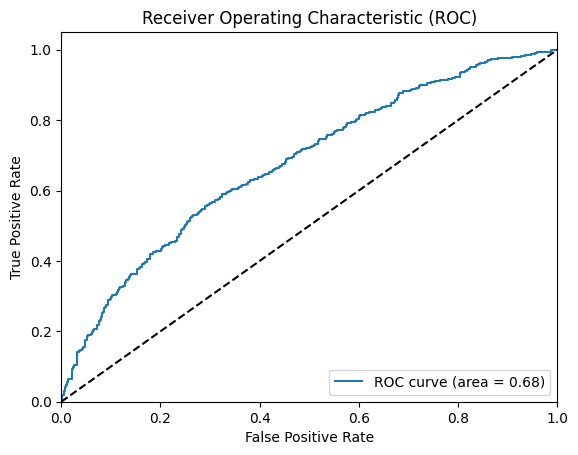

In [478]:
from sklearn.metrics import roc_curve, auc

y_score = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
grid_search.score(df_pro_test.drop(columns = ['result']), df_pro_test['result'])

In [480]:
df_gg = df_pro.loc[(df_pro['league_id'].isin([15475, 15438]) & (df_pro['match_id'] > 7213882342))]

In [481]:
df_gg.shape

(336, 294)

In [482]:
df_gg['predict'] = grid_search.predict(df_pro_test.drop(columns = ['result']))

In [483]:
df_gg['predict_proba'] = grid_search.predict_proba(df_pro_test.drop(columns = ['result'])).max(axis=1)

In [484]:
df_gg[['match_id', 'predict', 'predict_proba', 'result']]

,match_id,predict,predict_proba,result
0,7230110109,0,0.639238,0
1,7230050142,1,0.702858,1
2,7230010951,1,0.619981,1
3,7229957170,0,0.686098,0
4,7229895052,0,0.628092,0
...,...,...,...,...
4014,7248144462,1,0.651742,1
4015,7248157543,0,0.867367,0
4016,7249315898,1,0.652704,1
4017,7252117797,0,0.762940,0


In [ ]:
len(df_gg)

In [ ]:
len(df_gg.loc[df_gg['result'] != df_gg['predict']])

In [487]:
with open("models/heroes_model_bali.pkl", "wb") as file: 
    pickle.dump(grid_search, file)